<a target="_blank" href="https://colab.research.google.com/github/fintech-dl-hse/course/blob/main/seminars/02_activations_initialization_dataloader_trainer/02_activations_initialization_dataloader_trainer.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# Вспоминаем прошлое занятие

### Зачем переопределялись операции сложения/умножения на семинаре?


In [17]:
class Value():
    """
    Класс-обертка над float'ами с поддержкой автоматического
    дифференциирования вычислений
    """

    def __init__(self, data: float, inputs=(), name=''):
        """
        Инициализирует объект Value.

        :param data: Числовое значение (float).
        :param inputs: Входные значения, участвующие в вычислениях. Используется для обратного прохода.
        :param name: Название операции (используется для отладки).
        """
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self.inputs = set(inputs)

    def __add__(self, other):
        """
        Выполняет операцию сложения с другим объектом Value.

        :param other: Другое число или объект Value.
        :return: Новый объект Value, представляющий сумму.
        """
        other = other if isinstance(other, Value) else Value(other)

        out = Value(self.data + other.data, inputs=(self, other), name='+')

        def _backward_closure():
            self.grad += out.grad * 1
            other.grad += out.grad * 1

        out._backward_closure = _backward_closure

        return out

    # out = self * other
    # частные производные:
    # d out / d self = other
    # d out / d other = self
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, inputs=(self, other), name='*')

        def _backward_closure():
            other.grad += self.data * out.grad
            self.grad += other.data * out.grad

        out._backward_closure = _backward_closure

        return out

    # relu(self) = max(0, self)
    # d out / d self = 0, если self < 0
    # d out / d self = 1, если self >= 0
    def relu(self):
        out = Value(0 if self.data <= 0 else self.data, inputs=(self,), name='ReLU')

        def _backward_closure():
            if out.data <= 0:
                self.grad += 0
            else:
                self.grad += 1 * out.grad

        out._backward_closure = _backward_closure

        return out

    def backward(self):
        """
        Выполняет обратное распространение (backpropagation),
        вычисляя градиенты для всех зависимых значений.
        """
        topo = []
        visited = set()

        def build_topo(v):
            """
            Рекурсивно строит топологический порядок узлов графа вычислений.
            """
            if v not in visited:
                visited.add(v)
                for child in v.inputs:
                    build_topo(child)
                topo.append(v)

        build_topo(self)
        self.grad = 1
        for v in reversed(topo):
            v._backward()

        return

    def __rmul__(self, other): # other * self
        return self * other

    def __radd__(self, other): # other + self
        return self + other

    def __neg__(self): # -self
        return self * -1

    def __rsub__(self, other): # other - self
        return other + (-self)





### Идейно пройдемся по коду автограда


Идейно:

1. Мы не хотим считать производные руками
2. Можно автоматизировать вычисление градиентов используя chain rule
3. Для того, чтобы вычислить градиент мы строим граф вычисления нейросети
4. Чтобы посчитать градиент вершины, надо знать нисходящий градиент и входящие аргументы (например, для вычисления градиента умножения)
5. Чтобы правильно вычислить градиенты графа, надо правильно его обойти. В этом нам поможет обратная топологическая сортировка графа. Важно, чтобы при вычислении значения градиента текущей вершины были посчитаны градиенты всех вершин, в которые входит ребро из текущей вершины.


# План семинара

* Функции активации
* Инициализация
* Разберемся с Dataset/Dataloader API
* Напишем базовый Trainer - класс с тренировочным циклом
* Пишем логи в tensorboard/wandb/swanlab
* Сохраняем/подгружаем чекпоинты
* Блиц




# Функции активации


In [8]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

data_t = torch.arange(-3, 3, 0.1)

In [18]:
relu_module = torch.nn.ReLU()

print(relu_module)
print("Is nn.Module?", isinstance(relu_module, nn.Module))
print("Parameters", list(relu_module.parameters()))

ReLU()
Is nn.Module? True
Parameters []


### Затухание градиентов

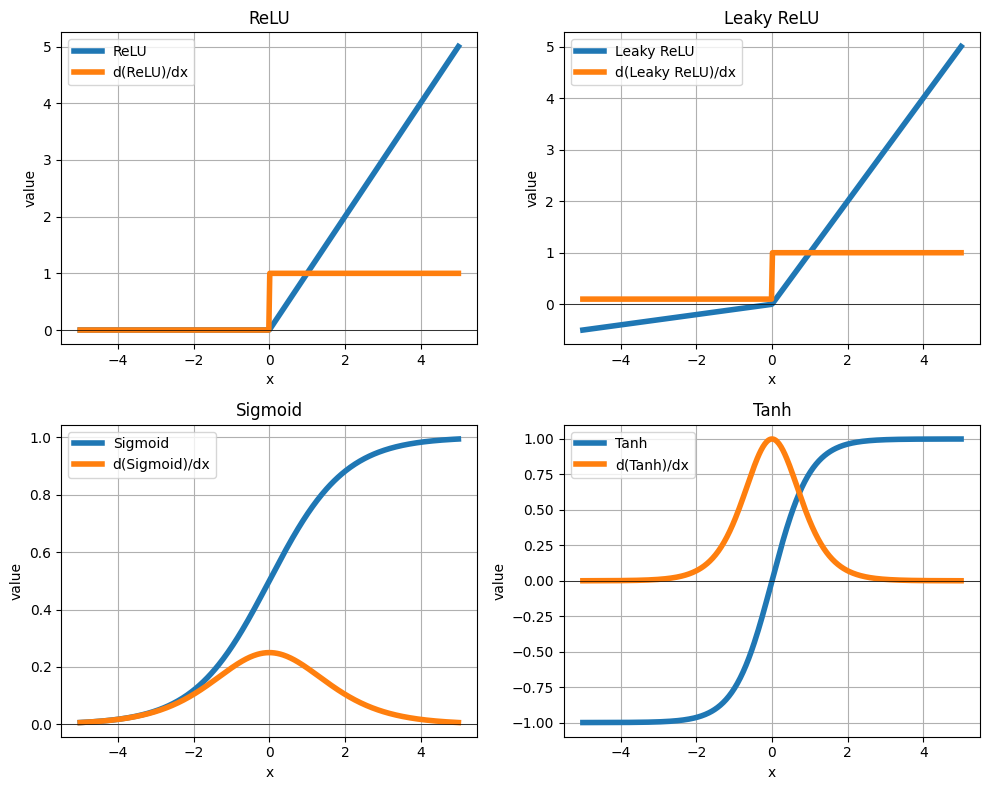

In [24]:
import torch
import matplotlib.pyplot as plt

x_min, x_max, n_points = -5, 5, 400

activations = [
    ("ReLU", torch.relu),
    ("Leaky ReLU", torch.nn.LeakyReLU(negative_slope=0.1)),
    ("Sigmoid", torch.sigmoid),
    ("Tanh", torch.tanh),
]

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

for ax, (name, act) in zip(axes, activations):
    x = torch.linspace(x_min, x_max, n_points, requires_grad=True)
    y = act(x)
    y.sum().backward()
    grad = x.grad

    ax.plot(x.detach(), y.detach(), label=name, linewidth=4)
    ax.plot(x.detach(), grad.detach(), label=f"d({name})/dx", linewidth=4)
    ax.axhline(0, color="black", linewidth=0.5)
    ax.set_title(name)
    ax.set_xlabel("x")
    ax.set_ylabel("value")
    ax.grid(True)
    ax.legend()

plt.tight_layout()



# Сравнение функций активации

| Функция | ✅ Плюсы | ❌ Минусы | Применение |
|---------|----------|-----------|------------|
| **Sigmoid** | • Выход как вероятность (0,1)<br>• Гладкая функция | • Затухающие градиенты<br>• Медленная<br>• Не центрирована | Выходной слой для бинарной классификации |
| **Tanh** | • Центрирована вокруг нуля<br>• Лучше чем sigmoid | • Затухающие градиенты<br>• Медленная | Скрытые слои RNN/LSTM |
| **ReLU** | • Очень быстрая<br>• Нет затухающих градиентов<br>• Стандарт индустрии | • "Dying ReLU" проблема<br>• Не центрирована | **Стандарт для CNN и глубоких сетей** |
| **Leaky ReLU** | • Решает "dying ReLU"<br>• Быстрая | • Непостоянные результаты<br>• Выбор параметра α | Альтернатива ReLU при проблемах |

## Рекомендации
- **По умолчанию:** ReLU для скрытых слоев
- **Выходной слой:** Sigmoid (бинарная классификация), Softmax (многоклассовая)
- **RNN:** Tanh
- **Если ReLU не работает:** попробуйте Leaky ReLU

## Инициализация и связь с активациями


### Ключевые принципы:

* **Сохранение дисперсии**: инициализация должна поддерживать примерно одинаковую дисперсию активаций на всех слоях
* **Предотвращение затухания/взрыва градиентов**: правильная инициализация помогает градиентам распространяться через глубокие сети
* **Нарушение симметрии**: веса должны быть различными, чтобы нейроны учились разным признакам

### Интуиция

* **Forward pass**: дисперсия зависит от n_in (сколько входов суммируется)
* **Backward pass**: дисперсия градиента зависит от n_out (сколько путей градиент идет)

| Аспект | Xavier (для tanh/sigmoid) | He (для ReLU) |
|--------|---------------------------|---------------|
| **Дисперсия** | `2/(n_in + n_out)` | `2/n_in` |
| **Учет активации** | Сохраняет ~100% активаций | Компенсирует потерю 50% |
| **Производная** | Производная ≈ 1 в центре | Производная = 1 для x>0 |
| **Направления** | Балансирует forward/backward | Фокус на forward pass |
| **Симметрия** | Работает с симметричными функциями | Работает с несимметричными |

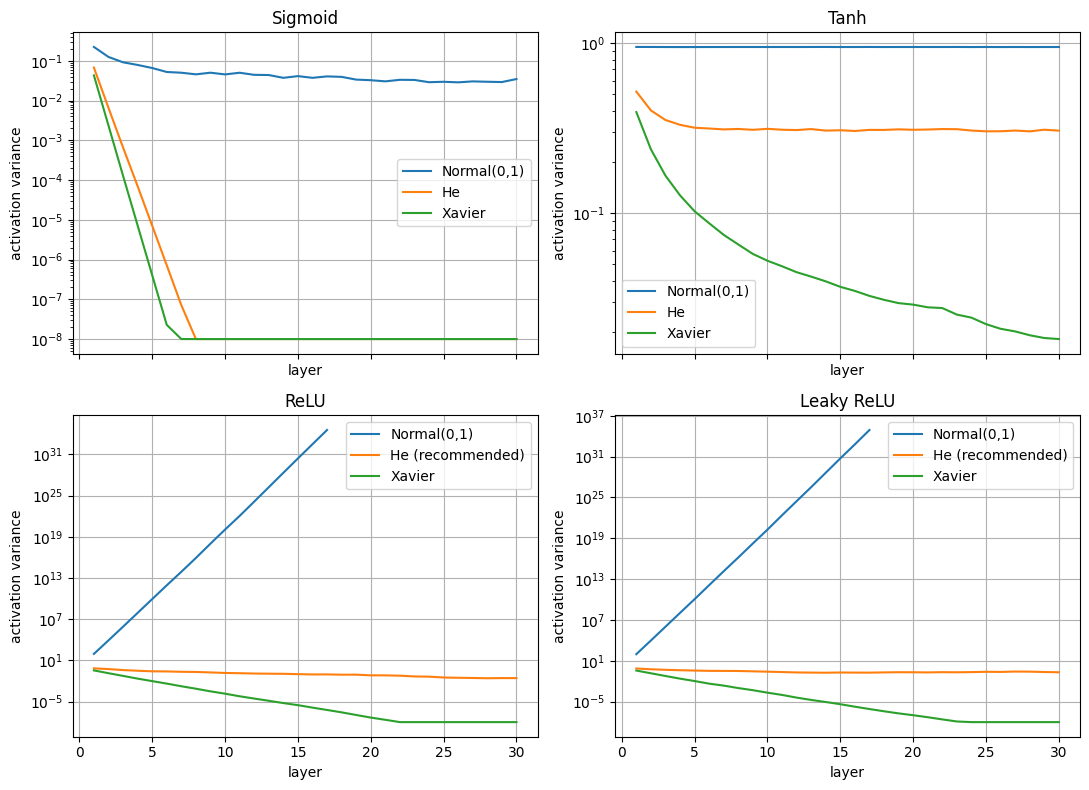

In [30]:
import torch
import matplotlib.pyplot as plt

torch.manual_seed(42)

batch_size = 1024
width = 256
n_layers = 30

def get_activation(name: str):
    if name == "Sigmoid":
        return torch.sigmoid
    if name == "Tanh":
        return torch.tanh
    if name == "ReLU":
        return torch.relu
    if name == "Leaky ReLU":
        return torch.nn.LeakyReLU(negative_slope=0.1)
    raise ValueError(f"Unknown activation: {name}")

# torch: torch.nn.init.normal_
def init_normal_(weight: torch.Tensor, mean: float = 0.0, std: float = 1.0):
    with torch.no_grad():
        weight.normal_(mean, std)


# torch: torch.nn.init.xavier_normal_
def init_xavier_(weight: torch.Tensor):
    fan_out, fan_in = weight.shape
    std = (2.0 / (fan_in + fan_out)) ** 0.5
    with torch.no_grad():
        weight.normal_(0.0, std)

# torch: torch.nn.init.kaiming_normal_
def init_he_(weight: torch.Tensor):
    fan_out, fan_in = weight.shape
    std = (2.0 / fan_in) ** 0.5
    with torch.no_grad():
        weight.normal_(0.0, std)


def init_weights(layer: torch.nn.Linear, method: str):
    if method == "Normal(0,1)":
        init_normal_(layer.weight, mean=0.0, std=1.0)
    elif method == "Xavier":
        init_xavier_(layer.weight)
    elif method == "He":
        init_he_(layer.weight)
    else:
        raise ValueError(f"Unknown init: {method}")


def simulate_variance(activation_name: str, init_method: str):
    x = torch.randn(batch_size, width)
    activation = get_activation(activation_name)
    variances = []

    for _ in range(n_layers):
        layer = torch.nn.Linear(width, width, bias=False)
        init_weights(layer, init_method)
        x = activation(layer(x))
        variances.append(x.var(dim=0, unbiased=False).mean().item())

    return [max(v, 1e-8) for v in variances]

activations = ["Sigmoid", "Tanh", "ReLU", "Leaky ReLU"]

fig, axes = plt.subplots(2, 2, figsize=(11, 8), sharex=True)
axes = axes.flatten()

for ax, act_name in zip(axes, activations):
    if act_name in {"Sigmoid", "Tanh"}:
        init_methods = [
            ("Normal(0,1)", "Normal(0,1)"),
            ("He", "He"),
            ("Xavier", "Xavier"),
        ]
    else:
        init_methods = [
            ("Normal(0,1)", "Normal(0,1)"),
            ("He", "He (recommended)"),
            ("Xavier", "Xavier"),
        ]

    for method, label in init_methods:
        variances = simulate_variance(act_name, method)
        ax.plot(range(1, n_layers + 1), variances, label=label)

    ax.set_title(act_name)
    ax.set_xlabel("layer")
    ax.set_ylabel("activation variance")
    ax.set_yscale("log")
    ax.grid(True)
    ax.legend()

plt.tight_layout()


### Вопрос: Кажется, что для сигмоиды отлично работает `Normal(0,1)`, но есть подвох - в чем он заключается?

# Lottery Ticket Hypothesis

<video controls>
    <source src="https://github.com/fintech-dl-hse/course/raw/refs/heads/main/seminars/02_activations_initialization_dataloader_trainer/static/LotteryTicketHypothesis.mp4" type="video/mp4">
    Your browser does not support the video tag.
</video>

# Практика обучения моделей


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import wandb

from tqdm.auto import tqdm

## Dataset API


<img src="https://github.com/fintech-dl-hse/course/raw/refs/heads/main/seminars/02_activations_initialization_dataloader_trainer/static/fish_data_dataset_dataloader.png" width="400" />


Подготовка данных легко может стать бутылочным горлышком, когда на подготовку очередного батча уходит больше времени, чем на forward+backward проходы по сети.
Проблема усложняется особенностями python: чтобы использовать несколько ядер CPU для подготовки данных надо постараться.

В Pytorch работа с данными строится на двух классах из [torch.utils.data](https://pytorch.org/docs/stable/data.html): `Dataset` и `DataLoader`:

- **`Dataset`** отвечает за подготовку одного примера
- **`DataLoader`** отвечает за выбор примеров, склейку их в один батч и распараллеливание на CPU, поддерживает итерирование.


Для решения задачи обычно пишут кастомные Dataset-классы, для этого нужно написать всего две функции:
- `.__len__(self)` возвращает количество примеров в датасете;
- `.__getitem__(self, i)` возвращает i-тый по счету пример из датасета.

Задачи DataLoader достаточно сложно аккуратно реализовать и лучше использовать готовый. Он довольно гибкий, все основные моменты кастомизируются заданием функций:
```
torch.utils.data.DataLoader(
    dataset,            # экземпляр класса Dataset, из которого надо доставать элементы
    batch_size=1,       # количество примеров в батче
    shuffle=False,      # перемешивать ли элементов
    num_workers=0,      # на сколько процессов запараллелить подготовку данных
    collate_fn=None,    # функция, которая будет склеивать элементы в батчи
    pin_memory=False,   # Более быстрый доступ к памяти

    # Редкоиспользуемые параметры:
    drop_last=False,    # нужно ли при итерировании выбрасывать неполные батчи? (такое бывает, если число примеров не делится нацело на batch_size
    sampler=None,       # определяет выбор элементов для батча
    batch_sampler=None, # как `sampler`, но возвращает индексы, а не элементы
    timeout=0,
    worker_init_fn=None,
    multiprocessing_context=None,
    generator=None)
```

Напишем два датасета для работы с `FashionMnist`:
1) Один готовит данные как вектора
2) Другой как картинки

**NB: FashionMNIST возвращает картинки в формате PIL.Image.Image, чтобы сделать из него понятный np.array, просто вызовите np.array(PIL_IMAGE)**

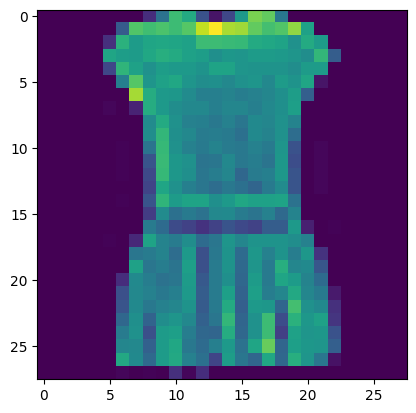

In [ ]:
from torchvision.datasets import FashionMNIST
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
fmnist = FashionMNIST("./tmp", train=True, download=True)

plt.imshow(fmnist[3][0])

In [ ]:
np.array(fmnist[0][0]).shape

(28, 28)

In [ ]:
from collections import namedtuple
from torchvision.datasets import FashionMNIST

class VectorSet:
    """
    Класс-обертка для набора данных FashionMNIST, преобразующий изображения в векторы.
    """
    def __init__(self, train=True):
        self.data = FashionMNIST("./tmp", train=train, download=True)

    def __len__(self):
        """
        Возвращает количество примеров в наборе данных.
        Обязательный метод для датасета.
        """
        return len(self.data)

    def __getitem__(self, item: int):
        """
        Возвращает один элемент из набора данных, преобразуя изображение в вектор.
        Нормирует значения пикселов в диапозон [0, 1].

        :param item: Индекс элемента.
        :return: Словарь с полями 'sample' (вектор изображения) и 'label' (метка класса).
        """

        sample, label = self.data[item]
        sample = np.array(sample, dtype=np.float32).reshape(-1) / 255
        return dict(
            sample=sample,
            label=label,
        )

vs = VectorSet()
print(vs[0]['sample'].shape)

class ImageSet:
    def __init__(self, train=True):
        self.data = FashionMNIST("./tmp", train=train, download=True)

    def __len__(self):
        """
        Возвращает количество примеров в наборе данных.
        Обязательный метод для датасета.
        """
        return len(self.data)

    def __getitem__(self, item):
        """
        Возвращает один элемент из набора данных. Нормирует значения пикселов в диапозон [0, 1].

        :param item: Индекс элемента.
        :return: Словарь с полями 'sample' (вектор изображения) и 'label' (метка класса).
        """
        # сделайте одноканальную картинку [1, 28, 28] с float32
        sample, label = self.data[item]
        sample = np.array(sample, dtype=np.float32)[None:, ...] / 255

        return dict(
            sample=sample,
            label=label,
        )

ms = ImageSet()
print(ms[0]['sample'].shape)

(784,)
(28, 28)


In [ ]:
# проверьте итерирование, именно его мы используем в train-loop'е
vl = DataLoader(vs, batch_size=4, shuffle=True)
for batch in vl:
    print("batch", type(batch))
    for k, v in batch.items():
        print(k, v.shape)
    break

batch <class 'dict'>
sample torch.Size([4, 784])
label torch.Size([4])


In [ ]:
# проверьте итерирование, именно его мы используем в train-loop'е
ml = DataLoader(ms, batch_size=4)
for batch in ml:
    for k, v in batch.items():
        print(k, v.shape)
    break

sample torch.Size([4, 28, 28])
label torch.Size([4])


## Замечания по Dataset/Dataloader

1. Dataset может возвращать что угодно (туплы, словари, whatever) с отдельными числами или массивами (numpy, torch.tensor).
Удобно возвращать словари с читабельными ключами, тогда будет проще разделять логику по компонентам.

2. Имеет смысл поглядеть в [стандартный collate_fn](https://github.com/pytorch/pytorch/blob/master/torch/utils/data/_utils/collate.py#L42): он умеет клеить в батчи и конвертировать в тензора самые разнообразные данные. Это может работать во многих случаях, но неожиданно падать в других. В частности, не сможет поклеить примеры разной длины.


## Вопросы

### За что отвечает `Dataset`?

### За что отвечает `DataLoader`?

### Зачем нужен `collate_fn`?

## Trainer


<img src="https://github.com/fintech-dl-hse/course/raw/refs/heads/main/seminars/02_activations_initialization_dataloader_trainer/static/i_see_training_loop.png" width="400" />

In [ ]:
from typing import Iterable
from torch.optim import Optimizer
from torch.utils.tensorboard import SummaryWriter

class Trainer:
    """
    Класс-абстракция для процесса обучения модели.
    Использует в себе все основные сущности:
        - модель
        - оптимизатор
        - Dataset
        - DataLoader
        -
    """
    def __init__(
            self,
            model: nn.Module,
            optimizer: Optimizer,
            train_dataset: Iterable,
            val_dataset: Iterable,
            batch_size=128
        ):
        """
        Инициализация тренера.

        :param model: Обучаемая модель.
        :param optimizer: Оптимизатор.
        :param train_dataset: Датасет для обучения.
        :param val_dataset: Датасет для валидации.
        :param batch_size: Размер батча.
        """

        self.model = model
        self.optimizer = optimizer
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset

        self.batch_size = batch_size

        self.device = 'cpu'
        if torch.cuda.is_available():
            self.device = torch.cuda.current_device()
            self.model = self.model.to(self.device)

        self.global_step = 0
        self.writer = SummaryWriter(log_dir="runs/02_seminar")

    def save_checkpoint(self, path: str):
        """
        Сохранение весов модели в указанный путь.

        :param path: Путь к файлу для сохранения.
        """
        torch.save(self.model.state_dict(), path)
        torch.save(self.optimizer.state_dict(), path.replace(".pth", "_optim.pth"))

    def train(self, num_epochs):
        """
        Запуск процесса обучения модели.

        :param num_epochs: Количество эпох обучения.
        """

        train_loader = DataLoader(self.train_dataset, shuffle=True, pin_memory=True, batch_size=self.batch_size)

        # валидационный датасет не стоит перемешивать
        val_loader = DataLoader(self.val_dataset, shuffle=False, pin_memory=True, batch_size=self.batch_size)
        best_loss = float('inf')

        model = self.model

        for epoch in range(num_epochs):
            model.train()
            for batch in tqdm(train_loader, desc=f"Epoch {epoch}"):
                self.training_step(batch)
                self.global_step += 1

            model.eval()

            val_losses = []
            for batch in tqdm(val_loader):
                loss = self.validation_step(batch)
                val_losses.append(loss.item())

            val_loss = np.mean(val_losses)
            self.writer.add_scalar("validation/loss", float(val_loss), epoch)
            # Сохраняем только наилучшую модель
            if val_loss < best_loss:
                self.save_checkpoint("./best_checkpoint.pth")
                best_loss = val_loss


    def training_step(self, batch):
        """
        Один шаг обучения: вычисление градиентов и обновление весов.

        :param batch: Батч данных для обучения.
        """
        self.optimizer.zero_grad()

        batch = {k: v.to(self.device) for k, v in batch.items()}
        loss, details = self.model.compute_all(batch)

        loss.backward()
        self.optimizer.step()

        # Логирование метрик обучения
        for k, v in details.items():
            self.writer.add_scalar(f"train/{k}", float(v), self.global_step)
        self.writer.add_scalar("train/loss", loss.item(), self.global_step) # Почему важно .item()?

        return

    def validation_step(self, batch):
        """
        Один шаг валидации: вычисление ошибки на валидационных данных.

        :param batch: Батч данных для валидации.
        :return: Потери (loss) модели на текущем батче.
        """

        batch = {k: v.to(self.device) for k, v in batch.items()}
        loss, details = self.model.compute_all(batch)

        return loss



In [ ]:
t = torch.tensor(1.5)

t, t.item()

(tensor(1.5000), 1.5)

## MLP

In [ ]:
class MLPModel(nn.Module):
    """
    Реализация MLP. Похожее мы уже видели на 1 и 2 семинаре.
    """

    def __init__(self, activation=None):
        """
        Инициализация модели.

        :param activation: Функция активации (по умолчанию ReLU).
        """
        super().__init__()

        if activation is None:
            activation = nn.ReLU()

        self.inner = nn.Sequential(
            nn.Linear(784, 100),
            # Dbg(),
            activation,
            nn.Linear(100, 10),
        )

        # nn.Sequential последовательно применяет переданные слои
        # self.linear_1 = nn.Linear(784, 100)
        # self.activation = nn.ReLU(),
        # self.linear_2 = nn.Linear(100, 10),

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Прямой проход данных через модель.

        :param x: Входные данные ~ [ bs, 784 ]
        :return: Выходные логиты модели ~ [ bs, 10 ]
        """
        return self.inner(x)

        # Эквивалентро применению sequential
        # out = self.linear_1(x)
        # out = self.activation(out)
        # out = self.linear_2(out)
        # return out

    def compute_all(self, batch):  # удобно сделать функцию, в которой вычисляется лосс по пришедшему батчу
        """
        Вычисляет лосс и точность по батчу данных.

        :param batch: Батч данных, содержащий 'sample' (входные данные) и 'label' (метки классов).
        :return: Значение функции потерь и словарь метрик.
        """

        x = batch['sample']    # [ bs, 784 ]
        y = batch['label']     # [ bs ] torch.LongTensor
        logits = self.inner(x) # [ bs, 10 ]

        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(axis=1) == y).float().mean().cpu().numpy()
        metrics = {
            "train_metrics/acc": acc,
            "train_metrics/loss": loss.detach().item(),
        }
        return loss, metrics

# проверяйте работоспособность сразу
model = MLPModel(activation=nn.Sigmoid())
# model = MLPModel()
opt = optim.SGD(model.parameters(), lr=1e-2)
trainset = VectorSet(train=True)
valset = VectorSet(train=False)

trainer = Trainer(model, opt, trainset, valset, batch_size=128)

In [ ]:
trainer.train(5)

Epoch 0:   0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

In [ ]:
class Dbg(nn.Module):
    def forward(self, x):
        print("x.shape", x.shape)
        return x

In [31]:
%%tensorboard --logdir=./runs/02_seminar

UsageError: Cell magic `%%tensorboard` not found.



## Запуск [Tensorboard](https://www.tensorflow.org/tensorboard) на виртуальной машине

```
tensorboard --logdirs=./some-folder/with/events-files
# зайти на http://localhost:6006
```
<img src="https://www.researchgate.net/publication/335864383/figure/fig1/AS:804107535265792@1568725584130/A-screen-capture-of-the-TensorBoard-output-from-a-model-trained-in-HIPSTER-on-simulated.jpg" width=400 />


## Логирование

| Библиотека | Сохранение метрик в облаке | Удобство использования |
|------------|---------------------------|------------------------|
| **Wandb** | ✅ Да (основной режим) + self-hosted | Отличное, но требует VPN |
| **TensorBoard** | ❌ Нет (только local/self-hosted) | Глюченый дефолтный клиент |
| **ClearML** | ✅ Да + self-hosted | Неудобно |
| **SwanLab** | ✅ Да + self-hosted + local | Все на китайском |
| **Comet ML** | ✅ Да (основной режим) + self-hosted | Не знаю |
| **MLflow** | ⚠️ Опционально (через Databricks) | Не знаю |
| **Neptune.ai** | ✅ Да (основной режим) + self-hosted | Не знаю |
| **Aim** | ❌ Нет (только local/self-hosted) | Не знаю |


## SwanLab [[link](https://github.com/SwanHubX/SwanLab/blob/main/README_RU.md)]

In [ ]:
import swanlab

# Инициализация нового эксперимента SwanLab
swanlab.init(
    project="my-mlp",
    config={'learning-rate': 0.003},
)

# Запись метрик
for i in range(10):
    swanlab.log({"loss": i, "acc": i})

## Сохранение-загрузка тензоров и моделек

Нам часто бывает необходимо сохранить/загрузить веса модели в файл на диске.
Распространенное название для этого -- checkpoint.

У торчевых моделей (наследников torch.nn.Module) и оптимизаторов (наследников torch.optim.Optimizer) есть методы для получения и загрузки состояний:

`.state_dict()` возвращает словарь (или почти словарь) с весами

`.load_state_dict(some_dict)` загружает веса из словаря в модельку

Для сохранения/загрузки словарей с тензорами в файлы есть простые функции `torch.save(some_dict, path)` и `torch.load(path)`. Сравните с использованием pickle или json!


In [ ]:
import os
from pathlib import Path
from shutil import copyfile

some_model = nn.Sequential(nn.Linear(10, 10))
print(some_model.state_dict())

opt = optim.Adam(some_model.parameters())
print(opt.state_dict())

ckpt_dir = Path("./checkpoint")
ckpt_dir.mkdir(parents=True, exist_ok=True)

checkpoint = {
    "model_state": some_model.state_dict(),
    "optimizer_state": opt.state_dict(),
    "epoch": 1,
}

# Сохраняем общий чекпоинт
ckpt_path = ckpt_dir / "checkpoint.pt"
torch.save(checkpoint, ckpt_path)

# Загружаем из чекпоинта
loaded = torch.load(ckpt_path, map_location="cpu")
some_model.load_state_dict(loaded["model_state"])
opt.load_state_dict(loaded["optimizer_state"])
start_epoch = loaded["epoch"] + 1
print("resume from epoch", start_epoch)

# Safetensors (в PyTorch есть встроенные torch.save/torch.load)
try:
    from safetensors.torch import save_file, load_file

    save_file(some_model.state_dict(), str(ckpt_dir / "model.safetensors"))
    state = load_file(str(ckpt_dir / "model.safetensors"))
    some_model.load_state_dict(state)
except ImportError:
    print("safetensors not installed; skipping")


OrderedDict([('0.weight', tensor([[-0.0664, -0.1143,  0.0927,  0.2251, -0.1066,  0.0699,  0.0839,  0.1290,
          0.2634, -0.1207],
        [-0.0667, -0.0684,  0.2839, -0.1812, -0.0663, -0.2177, -0.1561,  0.2530,
         -0.1258,  0.0492],
        [ 0.0277, -0.1238,  0.0233, -0.1850, -0.3061,  0.1397,  0.0905,  0.0550,
         -0.1700, -0.3050],
        [ 0.2981, -0.0113,  0.1828,  0.2367,  0.2410,  0.2082, -0.1709, -0.2723,
         -0.0275,  0.2663],
        [ 0.0250,  0.0213, -0.2093,  0.1383,  0.0041,  0.0610, -0.0874, -0.2920,
         -0.1293, -0.2178],
        [-0.2060,  0.3007, -0.1237, -0.0175, -0.2875,  0.0112, -0.1040, -0.0917,
         -0.1510,  0.0197],
        [ 0.2770,  0.2413, -0.0847,  0.2721, -0.2573, -0.1065, -0.2707, -0.1601,
          0.1047, -0.2812],
        [-0.0505, -0.2201, -0.1225, -0.1742, -0.2167,  0.1323, -0.2703,  0.1405,
         -0.1572, -0.2330],
        [ 0.2996,  0.3131,  0.2423, -0.0556, -0.1100,  0.0063,  0.2777, -0.1559,
          0.0465,  0.

### Сравнение `torch.save` и `safetensors`

| Критерий | `torch.save` / `torch.load` | `safetensors` |
|---|---|---|
| Формат | pickle | безопасный бинарный |
| Безопасность | потенциальный RCE при загрузке непроверенных файлов | безопасная загрузка |
| Скорость | нормальная | обычно быстрее |
| Совместимость | полный объект (любые python-объекты) | только тензоры |
| Рекомендуется | быстрые эксперименты, свои файлы | обмен весами, прод |

### Стратегии чекпоинтинга

| Стратегия | Идея | Когда использовать |
|---|---|---|
| `last` | всегда перезаписывать последний чекпоинт | для возобновления обучения |
| `best` | сохранять, если метрика улучшилась | для выбора лучшей модели |
| `every_epoch` | сохранять в конце каждой эпохи | анализ динамики обучения |
| `every_k_steps` | сохранять каждые k шагов | очень длинные эпохи |
| `top_k` | хранить k лучших по метрике | баланс качества и места |


# Блиц по `Pytorch`

### Какие базовые абстракции можно выделить при обучении нейросети?

<!--
* датасет+dataloader
* модель (сама нейросеть)
* оптимизатор
* trainer -- класс, который отвечает за то, как именно должна обучаться модель

ЗЫ можно выделить и больше абстракций
 -->

### Что нужно сохранять для того, чтобы сохранить текущее состояние обучения/модели?

<!-- На саммо деле ответ уже есть в вопросе -- сохраняем `state_dict` для модели и для оптимизатора -->


### Зачем нужно сохранять текущее состояние модели?

<!--
Во-первых, если ничего не сохранить, то никак нельзя будет применить в будущем обученную сеть и после завершения процесса обученные веса просто выгрузятся из памяти и все.

Кроме финального сохранения весов может иметь смысл анализ промежуточных состояний сети - мы хотим знать, что происходит с весами в процессе обучения нейросети?
 -->


### Когда нужно сохранять состояние модели/оптимизатора?

<!--

Вообще говоря, зависит от конкретной задачи, датасета и цели.

Есть разные стратегии сохраннения чекпоинтов:
* можно сохранять чекпоинты в конце каждой эпохи
* можно сохранять N последних чекпоинта
* можно сохранять N лучших чекпоинтов (по метрике или лоссу)
* можно сохранять чекпоинты через k шагов обновления (если в эпохе очень много шагов)

 -->


### Чем отличается Dataset от Dataloader?
<!--
- `Dataset` отвечает за подготовку одного примера
- `DataLoader` отвечает за выбор примеров, склейку их в один батч и распараллеливание на CPU, поддерживает итерирование.
-->

### Зачем нужна `collate_fn`?

<!-- Функция, которая будет склеивать примеры в батчи -->

## Расставьте этапы обучения модели в правильном порядке

* получение примеров для обучения из датасета (`Dataset`)
* склеивание примеров объектов из датасета в батчи (`Dataloader`)
* обновление весов сети
* backward pass
* forward pass + вычисление лосса
* обнуление градиентов `model.zero_grad()`
* сохранение чекпоинта

<!--

Правильный порядок:

* получение примеров для обучения из датасета
* склеивание примеров объектов из датасета в батчи
* обнуление градиентов `model.zero_grad()`
* forward pass + вычисление лосса
* backward pass
* обновление весов сети
* [например, в конце эпохи] сохранение чекпоинта

 -->

### Почему при логировании лосса важно сделать `loss.item()`?

<!-- Чтобы не было утечки памяти. Дело в том, что логгер хранит переданные значения в оперативной памяти. А к переменной `loss` привязан весь граф вычислений (в том числе, значения активаций с промежуточных слоев - вспоминаем прошлый семинар) -->


# Блиц по функциям активации

### Что вы запомнили про ф-и активации?


### Можно ли ставить ф-ии активации после последнего линейного слоя в MLP?

<!--
В теории можно, но в общем случае не рекомендуется.
Могут хуже течь градиенты, проблема dead neurons.

Важно понимать масштаб и диапозон данных, с которыми работает сеть на каждом этапе. Иногда выход из сети может ожидаться в диапозоне [-1, 1]. Иногда [0, 1]. Иногда нет никаких ограничений.

Чаще всего выход сети - это логиты. Которые мы потом преобразуем в вероятности через SoftMax.
 -->


# Блиц по инициализации

### Если инициализировать все веса нейросети нулями, то она не будет обучаться?

### Если не инициализировать веса нейросети, она не будет обучаться?

### Если инициализировать веса нейросети значениями > 1, она не будет обучаться?

### Если инициализировать веса нейросети значениями < 1, она не будет обучаться?

# Обзор домашки

Инвайты на домашку в закрепе чатике

<!--
https://github.com/fintech-dl-hse/hw-activations
https://github.com/fintech-dl-hse/hw-weight-init
-->

#### Pytorch inplace/outplace operations

По умолчанию любая операция и преобразование с тензорами должна возвращать копию тензора.

Но в торче для многих преобразований есть inplace модификация (с подчеркиванием на конце: `add_`, `mul_`, `exp_`, `fill_`)


In [ ]:
import torch

a = torch.randn(5)
b = torch.randn(5)

c = a + b # returns new tensor object
assert id(c) != id(a) and id(c) != id(b)

d = a.add_(b) # inplace add operation in `a` tensor memory

assert id(a) == id(d)
assert (d == a).all()

Это правило касается не только обычных операций с тензорами, но всех модулей (в том числе слои активаций).

inplace операций лучше избегать, если вы точно не уверены, что они вам нужны. Их плюс в том, что такие операции экономят память. Но из минусов можно в какой-то момент получить сломанный граф градиентов (если тензор, который был модифицирован inplace до этой модификации использовался для какой-либо операции, по которой мы хотим считать градиент)

Операция записи по индексам в тензор делается inplace.



In [ ]:
mytensor = torch.rand([10,10])
mask = torch.zeros_like(mytensor).bool() # configure boolean mask

mytensor[mask] = 0 # inplace operation

Поэтому если мы хотим сделать такое в нашем модуле, перед такой операцией надо явно создать клон тензора.

Когда не нужно явно клонировать тензор? В 99% случаев не нужно Для сигмоиды явно клонировать значение тензора не нужно, потому что `torch.exp(...)` и так возвращает новый тензор и не используются inplace операции

# Квииз!



![](http://qrcoder.ru/code/?https%3A%2F%2Ft.me%2Ffintech_dl_hse_bot&4&0)